## Modeling for predicting 72h ED revisit at ED discharge

Flow:
1. Task-specific filter
2. Variable selection
3. Modeling script
4. Performance output


### Load train and test

In [1]:
import os
import time
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import load_model
from helpers6 import PlotROCCurve, get_lstm_data_gen
confidence_interval = 95
random_seed=0

In [2]:
df_master = pd.read_csv('tidy_dataset_3-REV19AUGAMPM.csv')
df=df_master.copy()
pd.set_option("display.max_columns", 4000)
pd.set_option("display.max_rows", 4000)

# Create variables from code

In [3]:
from helpers6 import add_score_REMS,add_score_NEWS2,add_score_MEWS,add_triage_MAP,add_score_NEWS

In [4]:
#remove subjID with more than 85 repeats
indexNames = df[ df['edstays_patients_on_subject'] >46 ].index
df.drop(indexNames , inplace=True)

In [5]:
def add_triage_MAP(df):
    df['triage_MAP'] = df['ed_sbp_last_recoded']*1/3 + df['ed_dbp_last_recoded']*2/3
    print("Variable 'add_triage_MAP' successfully added")

In [6]:
df.drop(['triage_temperature','triage_heartrate','triage_resprate','triage_o2sat','triage_sbp','triage_dbp'], axis=1, inplace=True)

In [7]:
df.rename(columns={'triage_temperature_recoded_2': 'triage_temperature','triage_heartrate_recoded': 'triage_heartrate',
                  'triage_resprate_recoded': 'triage_resprate','triage_o2sat_recoded': 'triage_o2sat','triage_sbp_recoded': 'triage_sbp',
                  'triage_dbp_recoded': 'triage_dbp'}, inplace=True)

In [8]:
df=df.dropna(subset = ['triage_sbp', 'triage_dbp'])

In [9]:
# create a column 'ed_death' to represent those dies in ED room
df['ed_death'] = np.where((df['deathtime']> df['intime_ed']) & (df['deathtime']< df['outtime_ed']), True, False)
df['score_CCI'] = df['cci_MI'] + df['cci_CHF'] + df['cci_PVD'] + df['cci_Stroke'] + df['cci_Dementia'] + df['cci_Pulmonary'] + df['cci_PUD'] + df['cci_Rheumatic'] +df['cci_Liver1']*1 + df['cci_Liver2']*3 + df['cci_DM1'] + df['cci_DM2']*2 +df['cci_Paralysis']*2 + df['cci_Renal']*2 + df['cci_Cancer1']*2 + df['cci_Cancer2']*6 + df['cci_HIV']*6
add_triage_MAP(df)
add_score_NEWS2(df)
add_score_REMS(df)
add_score_MEWS(df)
add_score_NEWS(df)

Variable 'add_triage_MAP' successfully added
Variable 'Score_NEWS2' successfully added
Variable 'Score_REMS' successfully added
Variable 'Score_MEWS' successfully added
Variable 'Score_NEWS' successfully added


In [10]:
#to determine number of ed visits in the past 30d
df['intime_ed'] = pd.to_datetime(df['intime_ed'], format='%Y/%m/%d %H:%M:%S %p')
df['outtime_ed'] = pd.to_datetime(df['outtime_ed'], format='%Y/%m/%d %H:%M:%S %p')
df.sort_values(by=['subject_id','intime_ed'], inplace=True)
df=df.reset_index()

In [11]:
from datetime import timedelta
timerange_delta = timedelta(days=30)
N = len(df)
n_ed = [0 for _ in range(N)]

In [12]:
    def get_num_past_ed_visits(df):
        start = df.index[0]
        for i in df.index:
            if i % 10000 == 0:
                print('Process: %d/%d' % (i, N), end='\r')
            while df.loc[i, 'intime_ed'] - df.loc[start, 'intime_ed'] > timerange_delta:
                start += 1
            n_ed[i] = i - start

    grouped = df.groupby('subject_id')
    grouped.apply(get_num_past_ed_visits)
    print('Process: %d/%d' % (N, N), end='\r')

    df.loc[:, ''.join(['n_ed_', str(30), "d"])] = n_ed

In [13]:
#Check null values
df=df.dropna(subset=['age', 'gender','triage_acuity'])
df.isnull().sum()

index                                0
subject_id                           0
in_year                              0
edstays_patients_on_subject          0
intime_ed_hour                       0
hadm_id                         223654
stay_id                              0
intime_ed                            0
outtime_ed                           0
anchor_age                           0
gender                               0
anchor_year                          0
dod                             357455
admittime                       223763
dischtime                       223763
deathtime                       414034
race                            138534
race_recoded                    138534
edregtime                       223811
edouttime                       223811
insurance                       223763
age                                  0
before_ed_mortality                  0
outcome_hospitalization              0
outcome_inhospital_mortality         0
intime_icu               

In [14]:
#data wrangling for hos_los & icu_los
df['icu_los'] = df['icu_los'].fillna(-1)
df['hos_los'] = df['hos_los'].mask(df['hos_los'] < 0, -1)
df['hos_los'] = df['hos_los'].fillna (-1)

/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [15]:
#create variable to aggregate ECI
df['sum_eci']=df['eci_CHF']+df['eci_Arrhythmia']+df['eci_Valvular']+df['eci_PHTN']+df['eci_PVD']+df['eci_HTN1']+ df['eci_HTN2']+df['eci_Paralysis']+df['eci_NeuroOther']+df['eci_Pulmonary']+df['eci_DM1']+df['eci_DM2']+df['eci_Hypothyroid']+ df['eci_Renal']+df['eci_Liver']+df['eci_PUD']+df['eci_HIV']+df['eci_Lymphoma']+df['eci_Tumor2']+df['eci_Tumor1'] +df['eci_Rheumatic']+df['eci_Coagulopathy']+df['eci_Obesity']+df['eci_WeightLoss']+df['eci_FluidsLytes']+df['eci_BloodLoss'] +df['eci_Anemia']+df['eci_Alcohol']+df['eci_Drugs']+df['eci_Psychoses']+df['eci_Depression']

/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
#create variables to aggregate chiefcom

df[["chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache", 
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope",
            "chiefcom_dizziness"]] = df[["chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache", 
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope",
            "chiefcom_dizziness"]].astype(int)


/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [17]:
df['sum_chiefcom']=df['chiefcom_chest_pain']+ df["chiefcom_abdominal_pain"]+ df["chiefcom_headache"]+ df["chiefcom_shortness_of_breath"]+ df["chiefcom_back_pain"]+ df["chiefcom_cough"]+ df["chiefcom_nausea_vomiting"]+ df["chiefcom_fever_chills"]+ df["chiefcom_syncope"]+df["chiefcom_dizziness"]

/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [18]:
df['sum_chiefcom'].describe()

count    417172.000000
mean          0.395130
std           0.570093
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           4.000000
Name: sum_chiefcom, dtype: float64

# Model split

In [19]:
from sklearn.model_selection import train_test_split
# split into test and train set
df_train, df_test = train_test_split(df, test_size=0.2, random_state=25)
print(f"No. of training examples: {df_train.shape[0]}")
print(f"No. of test examples: {df_test.shape[0]}")

No. of training examples: 333737
No. of test examples: 83435


In [20]:
df_train.to_csv('train.csv')
df_test.to_csv('test.csv')

In [21]:
# exclude ED death cases for train and test
df_train = df_train[(df_train['before_ed_mortality'] == False) & (df_train['ed_death'] == False)].reset_index()
df_test = df_test[(df_test['before_ed_mortality'] == False) & (df_test['ed_death'] == False)].reset_index()
print(f"No. of training examples: {df_train.shape[0]}")
print(f"No. of test examples: {df_test.shape[0]}")

No. of training examples: 333710
No. of test examples: 83430


### 2. Variable Selection

In [22]:
variable = ["triage_MAP","age", "gender", "score_CCI","n_ed_30d","intime_ed_hour",

            "triage_pain_recoded", "triage_acuity","icu_los","hos_los","ed_los",
            
            'sum_chiefcom',
            
            "sum_eci",
            
            "ed_temperature_last_recoded", "ed_heartrate_last_recoded", "ed_resprate_last_recoded", 
            "ed_o2sat_last_recoded", "n_med", "n_medrecon"]

outcome = "outcome_ed_revisit_3d"

In [23]:
#Check datatypes of the variables
df[variable].isnull().sum()

triage_MAP                     0
age                            0
gender                         0
score_CCI                      0
n_ed_30d                       0
intime_ed_hour                 0
triage_pain_recoded            0
triage_acuity                  0
icu_los                        0
hos_los                        0
ed_los                         0
sum_chiefcom                   0
sum_eci                        0
ed_temperature_last_recoded    0
ed_heartrate_last_recoded      0
ed_resprate_last_recoded       0
ed_o2sat_last_recoded          0
n_med                          0
n_medrecon                     0
dtype: int64

In [24]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [25]:
X_train.dtypes.to_frame().T

,triage_MAP,age,gender,score_CCI,n_ed_30d,intime_ed_hour,triage_pain_recoded,triage_acuity,icu_los,hos_los,ed_los,sum_chiefcom,sum_eci,ed_temperature_last_recoded,ed_heartrate_last_recoded,ed_resprate_last_recoded,ed_o2sat_last_recoded,n_med,n_medrecon
0,float64,float64,object,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64,float64,float64,int64,float64,int64,int64


In [26]:
encoder = LabelEncoder()
X_train['gender'] = encoder.fit_transform(X_train['gender'])
X_test['gender'] = encoder.transform(X_test['gender'])

In [27]:
X_train['ed_los'] = pd.to_timedelta(X_train['ed_los']).dt.seconds / 60
X_test['ed_los'] = pd.to_timedelta(X_test['ed_los']).dt.seconds / 60

In [28]:
print('class ratio')
ratio = y_train.sum()/(~y_train).sum()
print('positive : negative =', ratio, ': 1')

class ratio
positive : negative = 0.030990580173567022 : 1


### 3.  Modeling script

In [29]:
# Containers for all results
result_list = []

In [30]:
def get_score_performance(s, random_seed=0):
    print(s)
    score = np.array(df_test[s])
    result = PlotROCCurve(score,y_test, ci=confidence_interval, random_seed=random_seed)
    runtime = 0
    results = [s]
    results.extend(result)
    results.append(runtime)
    result_list.append(results)

triage_acuity
AUC: 0.5584292979876886
AUPRC: 0.03375982833209265
Sensitivity: 0.7423510466988728
Specificity: 0.3841326316309639
Score thresold: 3.0
2.5 97.5


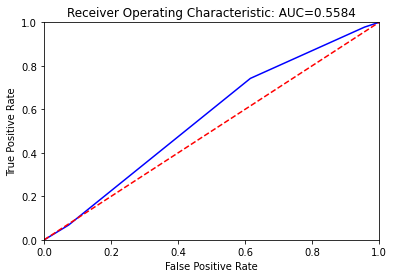

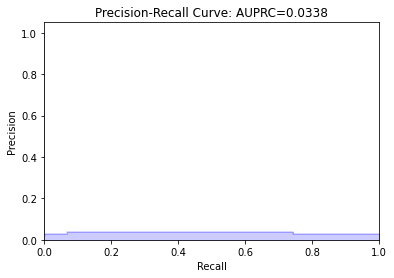

In [31]:
get_score_performance("triage_acuity", random_seed=random_seed)

Logistic Regression:


/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Training time: 3.6366078853607178 seconds
AUC: 0.7445290757246448
AUPRC: 0.09764252122639448
Sensitivity: 0.6723027375201288
Specificity: 0.670175178514071
Score thresold: 0.03400584834717566
2.5 97.5


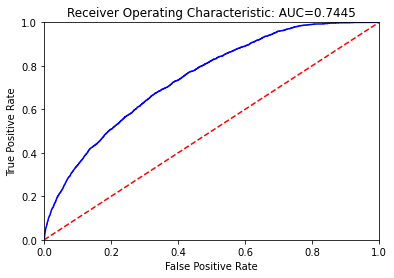

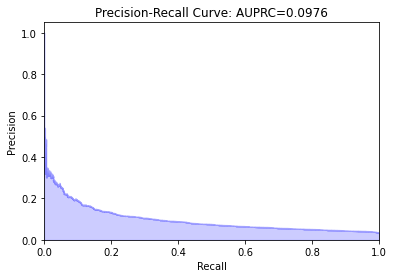

In [32]:
print("Logistic Regression:")
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression()
start = time.time()
logreg.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = logreg.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["LR"]
results.extend(result)
results.append(runtime)
result_list.append(results)

RandomForest:
Training time: 82.16803097724915 seconds
AUC: 0.7128612346403138
AUPRC: 0.08429700516642545
Sensitivity: 0.6517713365539453
Specificity: 0.650087712796185
Score thresold: 0.034
2.5 97.5


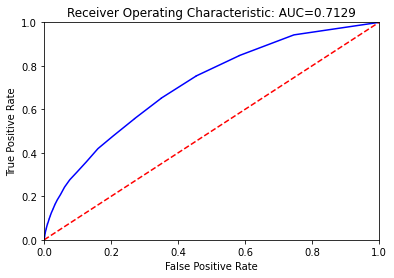

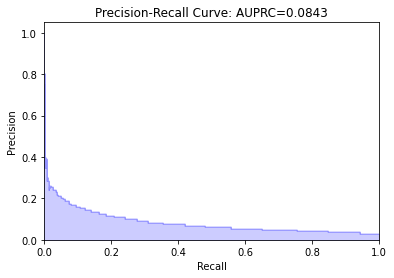

[0.12161988 0.11392577 0.01727056 0.0262861  0.02672837 0.09115479
 0.04964217 0.02444669 0.00232128 0.04900254 0.         0.0250639
 0.03838782 0.08885499 0.10182332 0.04830719 0.05092819 0.05674883
 0.06748762]


In [33]:
print("RandomForest:")
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier()
start = time.time()
rf.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
importances = rf.feature_importances_
print(importances)

results = ["RF"]
results.extend(result)
results.append(runtime)
result_list.append(results)

GradientBoosting:
Training time: 81.11968326568604 seconds
AUC: 0.7552786478236242
AUPRC: 0.10671681915705424
Sensitivity: 0.6839774557165862
Specificity: 0.6692733427223088
Score thresold: 0.0318598855858979
2.5 97.5


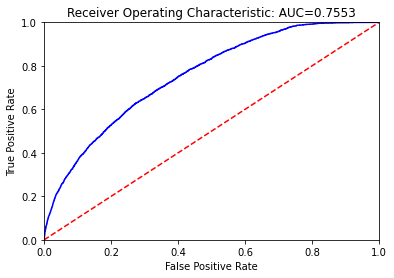

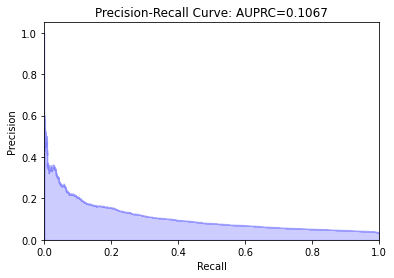

In [34]:
print("GradientBoosting:")
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
start = time.time()
gb.fit(X_train, y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["GB"]
results.extend(result)
results.append(runtime)
result_list.append(results)

score_NEWS
AUC: 0.49945157370773374
AUPRC: 0.029163779696598776
Sensitivity: 0.4883252818035427
Specificity: 0.5219034912163665
Score thresold: 3
2.5 97.5


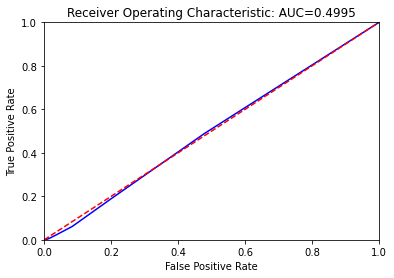

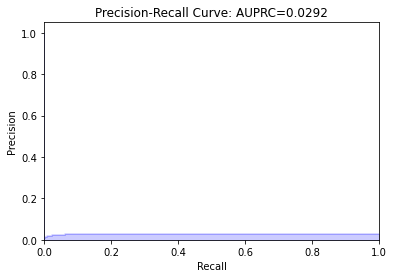

In [35]:
get_score_performance("score_NEWS", random_seed=random_seed)

score_NEWS2
AUC: 0.5036641691864874
AUPRC: 0.029460294532582983
Sensitivity: 0.4573268921095008
Specificity: 0.5605959528574606
Score thresold: 3
2.5 97.5


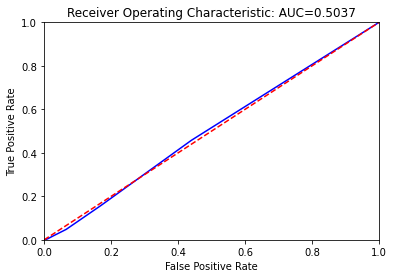

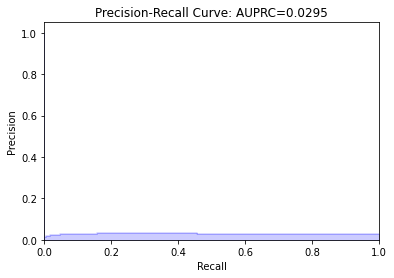

In [36]:
get_score_performance("score_NEWS2", random_seed=random_seed)

score_REMS
AUC: 0.45290763960530656
AUPRC: 0.02647701584628532
Sensitivity: 0.4758454106280193
Specificity: 0.4459639759839893
Score thresold: 3
2.5 97.5


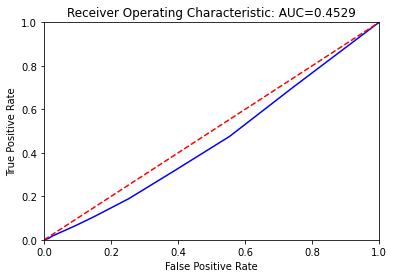

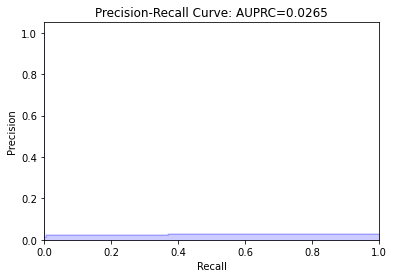

In [37]:
get_score_performance("score_REMS", random_seed=random_seed)

score_MEWS
AUC: 0.5074124559013975
AUPRC: 0.03006588242863243
Sensitivity: 0.24798711755233493
Specificity: 0.760605835989425
Score thresold: 4
2.5 97.5


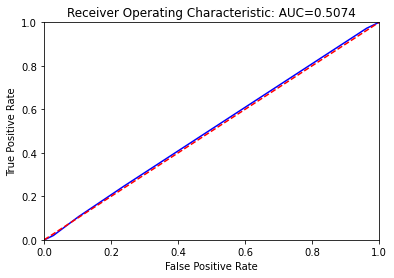

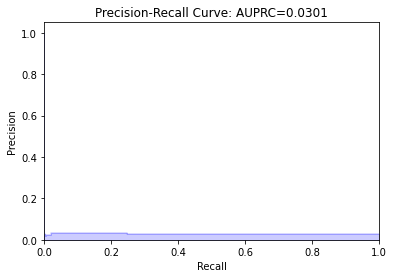

In [38]:
get_score_performance("score_MEWS", random_seed=random_seed)

In [39]:
class MLP(tf.keras.Model):
    def __init__(self):
        super(MLP, self).__init__()
        self.dense_1 = Dense(128, activation='relu')
        self.dense_2 = Dense(64, activation='relu')
        self.classifier = Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.classifier(x)

### 4. Performance output

In [40]:
#result_df = pd.read_csv(os.path.join(path, 'result_72h_ed_revivist_disposition.csv'))
result_df = pd.DataFrame(result_list, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
result_df.to_csv('result_72h_ed_revivist_disposition.csv')
result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
formatted_result_df.to_csv('task3.csv')
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,triage_acuity,3.000,0.558 (0.549-0.564),0.034 (0.033-0.035),0.742 (0.728-0.756),0.384 (0.381-0.387),0.000
1,LR,0.034,0.745 (0.739-0.755),0.098 (0.092-0.108),0.672 (0.664-0.697),0.67 (0.659-0.679),3.637
2,RF,0.034,0.713 (0.708-0.721),0.084 (0.08-0.094),0.652 (0.639-0.669),0.65 (0.647-0.653),82.168
3,GB,0.032,0.755 (0.749-0.765),0.107 (0.1-0.118),0.684 (0.633-0.704),0.669 (0.656-0.723),81.120
4,score_NEWS,3.000,0.499 (0.489-0.505),0.029 (0.028-0.03),0.488 (0.469-0.498),0.522 (0.52-0.523),0.000
5,score_NEWS2,3.000,0.504 (0.493-0.509),0.029 (0.028-0.03),0.457 (0.437-0.466),0.561 (0.558-0.562),0.000
6,score_REMS,3.000,0.453 (0.444-0.46),0.026 (0.025-0.027),0.476 (0.458-0.483),0.446 (0.443-0.449),0.000
7,score_MEWS,4.000,0.507 (0.499-0.511),0.03 (0.029-0.031),0.248 (0.233-0.256),0.761 (0.758-0.762),0.000


In [41]:
importance_df = pd.DataFrame(zip(variable, importances), columns=['Variable','Importance'])
importance_df.to_csv('importances_72h_ed_revisit_disposition.csv')
importance_df.sort_values(by='Importance', axis=0,ascending=False)

,Variable,Importance
0,triage_MAP,0.121620
1,age,0.113926
14,ed_heartrate_last_recoded,0.101823
5,intime_ed_hour,0.091155
13,ed_temperature_last_recoded,0.088855
18,n_medrecon,0.067488
17,n_med,0.056749
16,ed_o2sat_last_recoded,0.050928
6,triage_pain_recoded,0.049642
9,hos_los,0.049003


In [42]:
mlp = MLP()
mlp.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy', 'AUC',
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
start = time.time()
mlp.fit(X_train, y_train, batch_size=200, epochs=20)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')
mlp.save('hospitalization_triage_mlp')

ValueError: Please provide as model inputs either a single array or a list of arrays. You passed: inputs=        triage_MAP   age  gender  score_CCI  n_ed_30d  intime_ed_hour  \
0        86.666667  27.0       0          3         0               9   
1        62.333333  53.0       1          3         0              18   
2        90.333333  74.0       1          0         0              14   
3        83.333333  58.0       1          2         0               8   
4       128.000000  82.0       1          0         0              11   
...            ...   ...     ...        ...       ...             ...   
333705  101.000000  52.0       0          0         0              14   
333706   96.000000  59.0       1          7         1              19   
333707   81.333333  38.0       0          0         0              11   
333708   92.000000  36.0       0          0         0              16   
333709   73.666667  46.0       0          0         0              22   

        triage_pain_recoded  triage_acuity  icu_los  hos_los  ed_los  \
0                       7.0            3.0     -1.0     -1.0     0.0   
1                       0.0            2.0     -1.0    212.0     0.0   
2                       0.0            2.0    149.0    308.0     0.0   
3                       6.0            3.0     -1.0     17.0     0.0   
4                       0.0            1.0     -1.0     20.0     0.0   
...                     ...            ...      ...      ...     ...   
333705                  0.0            2.0     -1.0     64.0     0.0   
333706                  0.0            2.0     -1.0    157.0     0.0   
333707                  7.0            3.0     -1.0     -1.0     0.0   
333708                 10.0            2.0     -1.0     91.0     0.0   
333709                  7.0            2.0     -1.0     37.0     0.0   

        sum_chiefcom  sum_eci  ed_temperature_last_recoded  \
0                  0        2                         98.5   
1                  0        6                         99.4   
2                  0        0                         97.6   
3                  0        3                         98.0   
4                  0        0                         98.2   
...              ...      ...                          ...   
333705             0        0                         98.9   
333706             1       11                         97.6   
333707             1        1                         98.3   
333708             1        1                         98.1   
333709             1        0                         98.1   

        ed_heartrate_last_recoded  ed_resprate_last_recoded  \
0                            82.0                        14   
1                            88.0                        26   
2                            93.0                        16   
3                            70.0                        16   
4                            98.0                        19   
...                           ...                       ...   
333705                       89.0                        18   
333706                       85.0                        20   
333707                       78.0                        18   
333708                       78.0                        17   
333709                       58.0                        14   

        ed_o2sat_last_recoded  n_med  n_medrecon  
0                        99.0      0           7  
1                        99.0      2          22  
2                        92.0      1          13  
3                        99.0      3           1  
4                        98.0      8           4  
...                       ...    ...         ...  
333705                   95.0      0           2  
333706                   99.0      3          15  
333707                  100.0      2           1  
333708                   98.0      0           0  
333709                   95.0     11           2  

[333710 rows x 19 columns]

In [ ]:
print("MLP:")
mlp = load_model('72h_ed_revisit_mlp')
probs = mlp.predict(X_test.astype(np.float32))
result = PlotROCCurve(probs,y_test, ci=confidence_interval, random_seed=random_seed)
results = ["MLP"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [ ]:
# skip this cell if not retraining
mlp = MLP()
mlp.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy', 'AUC', {'auprc': metrics.AUC(name='auprc', curve='PR')}, 
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
start = time.time()
mlp.fit(X_train.astype(np.float32), y_train, batch_size=200, epochs=20)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')
mlp.save('72h_ed_revisit_mlp')

In [44]:
df1=df[variable,''].copy()
df1.to_csv('visualisation.csv')

In [45]:
df.to_csv('df-all.csv')